In [1]:
from keras.preprocessing.image import ImageDataGenerator
import keras
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!mkdir Train
!mkdir Test

!mkdir Train/Fake
!mkdir Train/Real

!mkdir Test/Fake
!mkdir Test/Real

In [3]:
# Repositioning the train data so that keras can read it.

PATH = "/kaggle/input/signature-verification-dataset/sign_data/train/"

for i in os.listdir(PATH):
    
    contol = i.split("_")
    
    try:
    
        if contol[1]=="forg":
            
            os.system("cp -r {} Train/Fake".format(PATH+i))
            
    except:
        
        os.system("cp -r {} Train/Real".format(PATH+i))

In [4]:
# Rearrange the test data in such a way that keras can read it.

PATH = "/kaggle/input/signature-verification-dataset/sign_data/test/"

for i in os.listdir(PATH):
    
    contol = i.split("_")
    
    try:
    
        if contol[1]=="forg":
            
            os.system("cp -r {} Test/Fake".format(PATH+i))
            
    except:
        
        os.system("cp -r {} Test/Real".format(PATH+i))

In [5]:
# locations

train_dir = os.path.join("/kaggle/working/Train") 

test_dir = os.path.join("/kaggle/working/Test")

In [6]:
train_datagen = ImageDataGenerator(

     # rescaling pixels between 0,1
      rescale=1./255,

     # Angle of random rotation of images in degrees (0-180)
      rotation_range=40,

     # horizontal and vertical scrolling ratios of images
      width_shift_range=0.2,

     # horizontal and vertical scrolling ratios of images
      height_shift_range=0.2,

      # sprain operation
      shear_range=0.2,
  
     # zoom operation
      zoom_range=0.2,

     # rotate image vertically
      horizontal_flip=True,

       # excess after processing
      # determines how the image points are filled
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(

        # target directory
        train_dir,

        # all images will be resized as (150x150)
        target_size=(200, 200),

        # batch or stack size
        batch_size=64,

         # binary tags required
        # because we are using binary_crossentropy
        class_mode='binary')

Found 1649 images belonging to 2 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(

        test_dir,

        target_size=(200, 200),

        batch_size=32,

        class_mode='binary')

Found 500 images belonging to 2 classes.


Label :  0.0


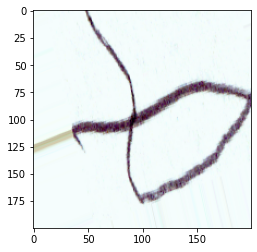

In [9]:
plt.imshow(train_generator[0][0][5])
print("Label : ",train_generator[0][1][5])

Label :  1.0


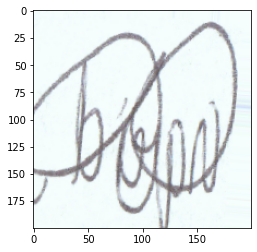

In [10]:
plt.imshow(train_generator[0][0][60])
print("Label : ",train_generator[0][1][60])

In [11]:
class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    
    self.cnn1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(3,200,200))
    self.cnn2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
    self.cnn3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
    
    self.flatten = tf.keras.layers.Flatten()
    
    self.dense1 = tf.keras.layers.Dense(512, activation='relu')
    self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    
    x = self.cnn1(inputs)
    x = self.cnn2(x)
    x = self.cnn3(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    
    return x

model = MyModel()

2021-12-27 04:00:08.080223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 04:00:08.172450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 04:00:08.173221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-27 04:00:08.174427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
input_shape = (None, 200, 200, 3)
model.build(input_shape)
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  448       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  4624      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  308314624 
_________________________________________________________________
dense_1 (Dense)              multiple                  513       
Total params: 308,324,849
Trainable params: 308,324,849
Non-trainable params: 0
____________________________________________

In [13]:
model.compile(
   # loss function
    loss="binary_crossentropy",
    
    # Optimization:
    # Considering the loss created by the data, which is the input of our network
    # self-update mechanism
    optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),

    # metrics to follow during training and testing. 
    metrics=["acc"])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
# We will get the acc, loss, val_acc, val_loss values from the variable named history.
history = model.fit_generator(

    # training data
    train_generator,

    # the number of samples it will run through until the loop finishes (stack to get)
    steps_per_epoch=train_generator.samples//train_generator.batch_size,

    # number of cycles
    epochs=40,

    verbose=2)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-27 04:00:11.060290: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2021-12-27 04:00:13.472286: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


25/25 - 26s - loss: 0.8665 - acc: 0.5009
Epoch 2/40
25/25 - 17s - loss: 0.7402 - acc: 0.5098
Epoch 3/40
25/25 - 18s - loss: 0.6953 - acc: 0.5868
Epoch 4/40
25/25 - 18s - loss: 0.6730 - acc: 0.5855
Epoch 5/40
25/25 - 18s - loss: 0.6360 - acc: 0.6385
Epoch 6/40
25/25 - 18s - loss: 0.6268 - acc: 0.6562
Epoch 7/40
25/25 - 17s - loss: 0.6083 - acc: 0.6751
Epoch 8/40
25/25 - 18s - loss: 0.5829 - acc: 0.6909
Epoch 9/40
25/25 - 18s - loss: 0.5670 - acc: 0.7028
Epoch 10/40
25/25 - 18s - loss: 0.5476 - acc: 0.7192
Epoch 11/40
25/25 - 18s - loss: 0.5285 - acc: 0.7401
Epoch 12/40
25/25 - 17s - loss: 0.5099 - acc: 0.7685
Epoch 13/40
25/25 - 18s - loss: 0.4982 - acc: 0.7685
Epoch 14/40
25/25 - 18s - loss: 0.4920 - acc: 0.7918
Epoch 15/40
25/25 - 17s - loss: 0.4716 - acc: 0.7918
Epoch 16/40
25/25 - 18s - loss: 0.4568 - acc: 0.7968
Epoch 17/40
25/25 - 18s - loss: 0.4406 - acc: 0.8169
Epoch 18/40
25/25 - 18s - loss: 0.4271 - acc: 0.8189
Epoch 19/40
25/25 - 18s - loss: 0.4193 - acc: 0.8353
Epoch 20/40
2

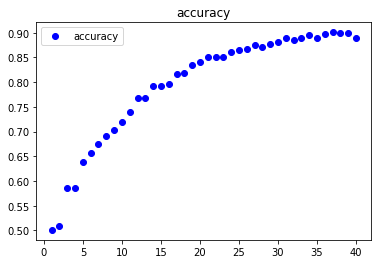

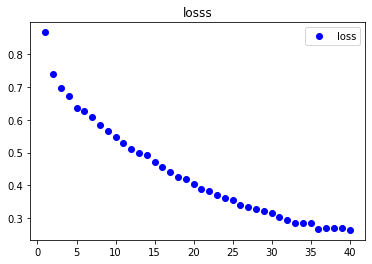

In [15]:
# accuracy score
acc = history.history["acc"]

# loss score
loss = history.history["loss"]

# We will plot graphs according to the number of epochs.
epochs = range(1, len(acc) + 1)

# We had training data drawn for itself..
plt.plot(epochs, acc, "bo", label="accuracy")

#the title of graph
plt.title("accuracy")

plt.legend()

plt.figure()

# we had training data drawn for itself.
plt.plot(epochs, loss, "bo", label="loss")


# the title of our graph
plt.title("losss")

plt.legend()

# display on screen
plt.show()

In [16]:
# Loss and verification with test data
model.evaluate(test_generator)

16/16 [==============================] - 2s 110ms/step - loss: 0.2996 - acc: 0.8680


[0.2995726764202118, 0.8679999709129333]

Label :  0.0
Predict :  0.0


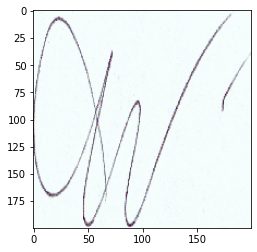

In [17]:
plt.imshow(test_generator[0][0][5])
print("Label : ",test_generator[0][1][5])

test_input = test_generator[0][0][5]
test_input = np.expand_dims(test_input,axis=0)
test_input = np.expand_dims(test_input,axis=0)
test_input = np.expand_dims(test_input,axis=0)

pred = model.predict(test_input)

if pred>=0.5:
    pred = 1
    
else:
    
    pred = 0
    
print("Predict : ",float(pred))

Label :  0.0
Predict :  0.0


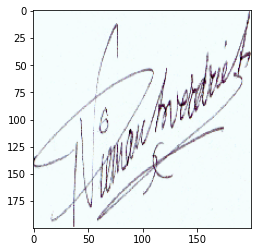

In [18]:
plt.imshow(test_generator[0][0][30])
print("Label : ",test_generator[0][1][30])

test_input = test_generator[0][0][30]
test_input = np.expand_dims(test_input,axis=0)
test_input = np.expand_dims(test_input,axis=0)
test_input = np.expand_dims(test_input,axis=0)

pred = model.predict(test_input)

if pred>=0.5:
    pred = 1
    
else:
    
    pred = 0
    
print("Predict : ",float(pred))